# BTS MV Trends

BTS is a K-pop group that has gained international recognition over the years. Since their debut in 2013, they have released multiple music videos with various genres. This project aims to extract data from the group's official music videos in youtube using the youtube API and look at the trends of these data.

## Data Cleaning

Given the JSON File extracted from the youtube API, we will be getting a dataframe of BTS official music videos and its relevant video details. 

In [1]:
import json
import pandas as pd
import re

file = open('bts_official_mv_data.json')

bts_official_mv_data = json.load(file)

raw_df = pd.json_normalize(bts_official_mv_data['items'])

raw_df.columns

Index(['kind', 'etag', 'id', 'snippet.publishedAt', 'snippet.channelId',
       'snippet.title', 'snippet.description',
       'snippet.thumbnails.default.url', 'snippet.thumbnails.default.width',
       'snippet.thumbnails.default.height', 'snippet.thumbnails.medium.url',
       'snippet.thumbnails.medium.width', 'snippet.thumbnails.medium.height',
       'snippet.thumbnails.high.url', 'snippet.thumbnails.high.width',
       'snippet.thumbnails.high.height', 'snippet.thumbnails.standard.url',
       'snippet.thumbnails.standard.width',
       'snippet.thumbnails.standard.height', 'snippet.thumbnails.maxres.url',
       'snippet.thumbnails.maxres.width', 'snippet.thumbnails.maxres.height',
       'snippet.channelTitle', 'snippet.tags', 'snippet.categoryId',
       'snippet.liveBroadcastContent', 'snippet.defaultLanguage',
       'snippet.localized.title', 'snippet.localized.description',
       'snippet.defaultAudioLanguage', 'contentDetails.duration',
       'contentDetails.dimension'

In [2]:
# filter dataframe to reflect relevant columns only
relevant_details= ['id', 'snippet.publishedAt', 'snippet.title', 'snippet.description', 'contentDetails.duration', 'statistics.viewCount', 'statistics.likeCount', 'statistics.commentCount']
df = raw_df.loc[:, relevant_details]

# rename columns
column_names = ['Video ID', 'Date', 'Title', 'Description', 'Duration', 'Number of Views', 'Number of Likes', 'Number of Comments']
df.columns = column_names

# check for null values and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Video ID            55 non-null     object
 1   Date                55 non-null     object
 2   Title               55 non-null     object
 3   Description         55 non-null     object
 4   Duration            55 non-null     object
 5   Number of Views     55 non-null     object
 6   Number of Likes     51 non-null     object
 7   Number of Comments  55 non-null     object
dtypes: object(8)
memory usage: 3.6+ KB


In [3]:
# check rows containing null values
df[df.isna().any(axis = 1)]

,Video ID,Date,Title,Description,Duration,Number of Views,Number of Likes,Number of Comments
38,a16gTN7kOWU,2016-03-11T09:00:01Z,BTS (防弾少年団) 'RUN -Japanese Ver.-' Official MV,防弾少年団、3月15日発売の日本6thシングル RUN -Japanese Ver.- のM...,PT3M56S,29981629,NaN,27571
39,LYAcYSmaLoc,2015-12-02T06:00:01Z,BTS (防弾少年団) 'I NEED U (Japanese Ver.)' Officia...,防弾少年団、12月8日発売の日本5thシングル I NEED U (Japanese Ver...,PT3M40S,48225529,NaN,24660
42,ULStzgQYrqk,2015-06-17T03:00:01Z,BTS (防弾少年団) 'FOR YOU' Official MV (Dance Ver.),防弾少年団、6月17日発売の日本4thシングル「FOR YOU」のミュージックビデオのダンス...,PT4M46S,28138590,NaN,16225
43,TTG6nxwdhyA,2015-06-05T03:00:00Z,BTS (防弾少年団) 'FOR YOU' Official MV,防弾少年団、6月17日発売の日本4thシングル「FOR YOU」のミュージックビデオ。\nオ...,PT5M7S,84566047,NaN,70264


There are null values for some entries because the number of likes for some videos was not made publicly available. Since the 'Number of Likes' column is independent of other factors, we cannot fill in the missing values. However, since we have a small dataset, we will leave the null values as it is.

Currently, all the columns have object data types. We must convert the 'Date' column into a datetime data type, the 'Duration' column into a timedelta datatype, and the 'Number of Views', 'Number of Likes', and 'Number of Comments' columns into integer datatypes.

In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['Date']).reset_index(drop = True)
df.insert(1,'Year', df['Date'].dt.year)


df['Duration'] = pd.to_timedelta(df['Duration'])
df.insert(6,'Duration (seconds)', df['Duration'].dt.seconds)

for column in ['Number of Views', 'Number of Likes','Number of Comments']:
    df[column] = pd.to_numeric(df[column], errors = 'coerce')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   Video ID            55 non-null     object             
 1   Year                55 non-null     int64              
 2   Date                55 non-null     datetime64[ns, UTC]
 3   Title               55 non-null     object             
 4   Description         55 non-null     object             
 5   Duration            55 non-null     timedelta64[ns]    
 6   Duration (seconds)  55 non-null     int64              
 7   Number of Views     55 non-null     int64              
 8   Number of Likes     51 non-null     float64            
 9   Number of Comments  55 non-null     int64              
dtypes: datetime64[ns, UTC](1), float64(1), int64(4), object(3), timedelta64[ns](1)
memory usage: 4.4+ KB


Lastly, we must remove the artist name and the word 'Official MV' from the video titles since it is already known that we will be looking at official music videos from the artist BTS.

In [5]:
df['Title'].values

array(["BTS (방탄소년단) 'No More Dream' Official MV",
       "BTS (방탄소년단) 'No More Dream' Official MV (Choreography Version)",
       "BTS (방탄소년단) 'We Are Bulletproof Pt.2' Official MV",
       "BTS (방탄소년단) 'N.O' Official MV",
       "BTS (방탄소년단) '상남자 (Boy In Luv)' Official MV",
       "BTS (방탄소년단) '상남자 (Boy In Luv)' Official MV (Choreography Version)",
       "BTS (방탄소년단) '하루만 (Just one day)' Official MV",
       "BTS (방탄소년단) 'Danger' Official MV",
       "BTS (방탄소년단) '호르몬전쟁' Official MV",
       "BTS (방탄소년단) 'I NEED U' Official MV",
       "BTS (방탄소년단) 'I NEED U' Official MV (Original ver.)",
       "BTS (防弾少年団) 'FOR YOU' Official MV",
       "BTS (防弾少年団) 'FOR YOU' Official MV (Dance Ver.)",
       "BTS (방탄소년단) '쩔어' Official MV", "BTS (방탄소년단) 'RUN' Official MV",
       "BTS (防弾少年団) 'I NEED U (Japanese Ver.)' Official MV",
       "BTS (防弾少年団) 'RUN -Japanese Ver.-' Official MV",
       "BTS (방탄소년단) 'EPILOGUE : Young Forever' Official MV",
       "BTS (방탄소년단) '불타오르네 (FIRE)' Official MV",
  

In [6]:
for index, raw_title in enumerate(df['Title']):
    
    title, version = re.split('Official MV', raw_title)
    split_title = re.split('[\'\‘\’]', title)
    clean_title = f"{''.join(split_title[1:])}{version}".strip()
    df.iloc[index, 3] = clean_title

title_list = df['Title'].values

title_list

array(['No More Dream', 'No More Dream  (Choreography Version)',
       'We Are Bulletproof Pt.2', 'N.O', '상남자 (Boy In Luv)',
       '상남자 (Boy In Luv)  (Choreography Version)', '하루만 (Just one day)',
       'Danger', '호르몬전쟁', 'I NEED U', 'I NEED U  (Original ver.)',
       'FOR YOU', 'FOR YOU  (Dance Ver.)', '쩔어', 'RUN',
       'I NEED U (Japanese Ver.)', 'RUN -Japanese Ver.-',
       'EPILOGUE : Young Forever', '불타오르네 (FIRE)',
       '불타오르네 (FIRE)  (Choreography Version)', 'Save ME',
       '피 땀 눈물 (Blood Sweat & Tears)', '봄날 (Spring Day)', 'Not Today',
       'Not Today  (Choreography Version)', '血、汗、涙 -Japanese Ver.-',
       'DNA', 'MIC Drop -Japanese ver.- (Short ver.)',
       'MIC Drop (Steve Aoki Remix)', 'MIC Drop -Japanese ver.-',
       'FAKE LOVE', 'FAKE LOVE  (Extended ver.)', 'IDOL',
       'IDOL (Feat. Nicki Minaj)', 'Airplane pt.2 -Japanese ver.-',
       '작은 것들을 위한 시 (Boy With Luv) (feat. Halsey)',
       "작은 것들을 위한 시 (Boy With Luv) (feat. Halsey)  ('ARMY With Luv' ver.

## Data Visualization

Now that we have organized the data, we can explore the relationship between our data. First, we must set up the notebook to display the data properly.

In [7]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.ticker import NullFormatter
import numpy as np
import seaborn as sns

# include Korean and Japanese fonts for graphs
korean_font_path = 'NotoSansKR-Regular.otf' # get font path
japanese_font_path = 'NotoSansJP-Regular.otf'

korean_font = fm.FontProperties(fname=korean_font_path)  # get the font based on the font path
japanese_font = fm.FontProperties(fname=japanese_font_path) 

# formatters for axis labels
def millions_formatter(x, pos):
    return str(round(x / 1e6, 1))

def billions_formatter(x, pos):
    return str(round(x / 1e9, 1))

Next, let us explore the correlations of the different variables using a heatmap.

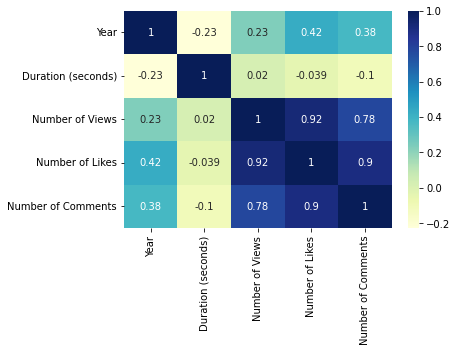

In [8]:
sns.heatmap(df.corr(), annot=True, cmap='YlGnBu')
plt.show()

We can see that the year the MV was released and the duration of the MV have a low correlation compared to other variables. Thus, we will focus on finding the trend between the Number of Views, Number of Likes, and Number of Comments.

/Users/angellazariselacson/.envs/test3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 28057 (\N{CJK UNIFIED IDEOGRAPH-6D99}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


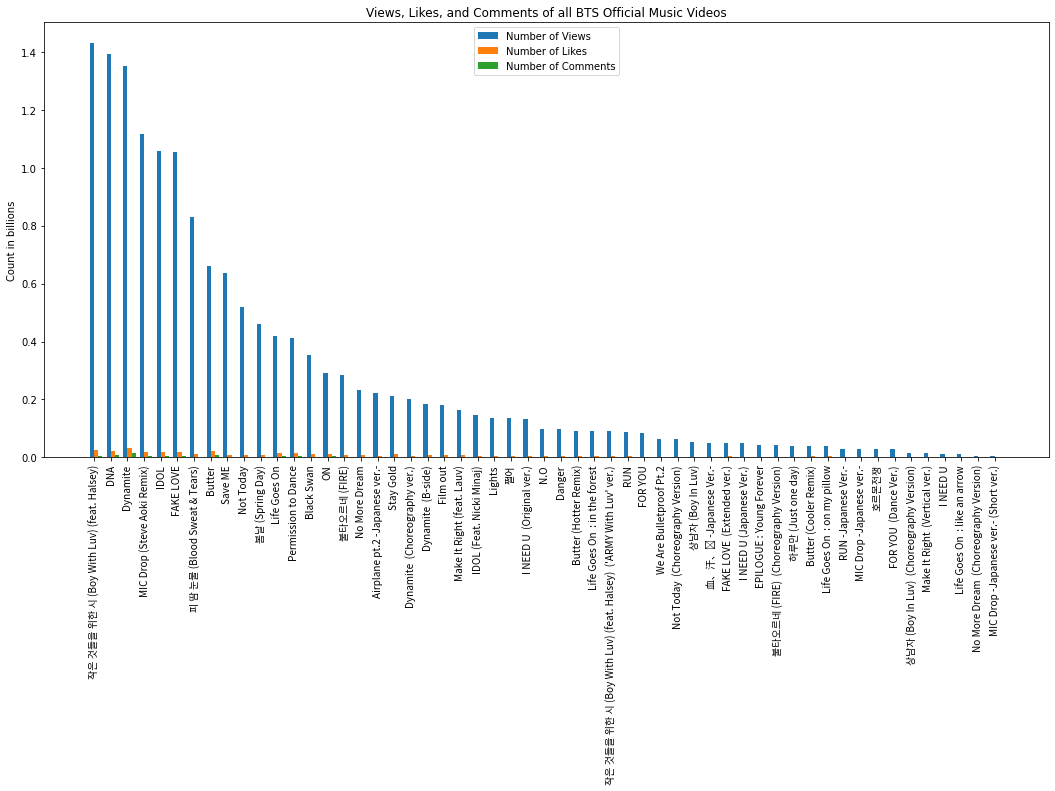

In [9]:
df_sorted_by_views = df.sort_values(['Number of Views'], ascending=False)
title_list_sorted_by_views = df_sorted_by_views['Title'].values

x = np.arange(len(title_list_sorted_by_views))  # the label locations
width = 0.25  # the width of the bars


fig_a, ax_a = plt.subplots(figsize=(18,8))
rects1_a = ax_a.bar(x - width, df_sorted_by_views['Number of Views'], width, label='Number of Views', align='edge')
rects2_a = ax_a.bar(x, df_sorted_by_views['Number of Likes'], width, label='Number of Likes', align='edge')
rects3_a = ax_a.bar(x + width,  df_sorted_by_views['Number of Comments'], width, label='Number of Comments', align='edge')

# Add some text for labels, title and custom x-axis tick labels, etc.

ax_a.set_title('Views, Likes, and Comments of all BTS Official Music Videos')
ax_a.set_xticks(x, title_list_sorted_by_views)
ax_a.set_xticklabels(title_list_sorted_by_views, rotation=90, font=korean_font)
ax_a.yaxis.set_major_formatter(billions_formatter)
ax_a.yaxis.set_minor_formatter(NullFormatter())
ax_a.set_ylabel("Count in billions")
ax_a.legend()

plt.show()

Based on the bar graph, we can see that Boy With Luv has the most number of views, while Dynamite has the highest number of likes and comments. Additionally, the Number of Views is significantly higher than the Number of Likes and Number of Comments for all official music videos. To take a closer look at the correlation between the three factors, we will be creating scatter plots.

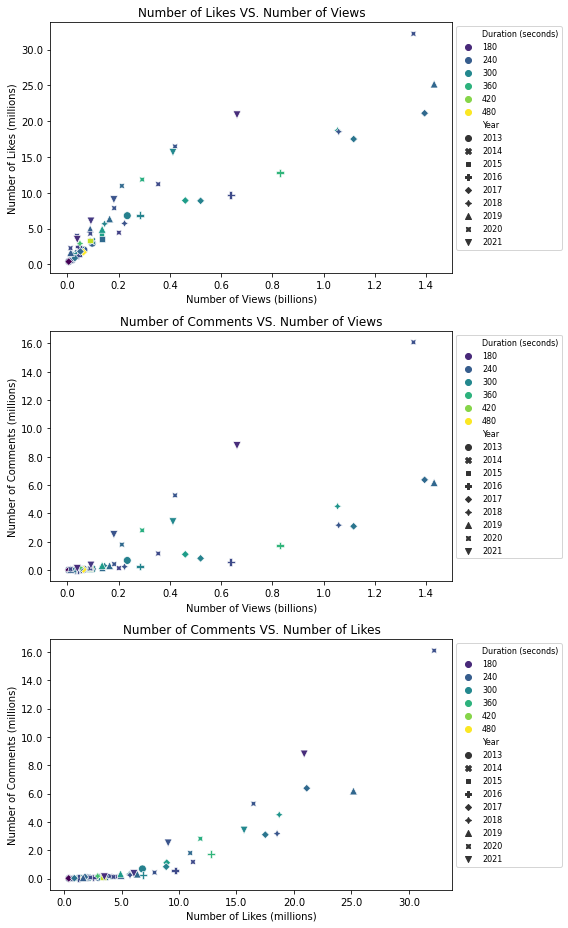

In [10]:
fig_b, ax_b = plt.subplots(3,1, figsize = (8,13))

sns.scatterplot(data=df, x='Number of Views', y='Number of Likes', s=60, style='Year', hue='Duration (seconds)', palette='viridis', ax=ax_b[0])
sns.scatterplot(data=df, x='Number of Views', y='Number of Comments', s=60, style='Year', hue='Duration (seconds)', palette='viridis', ax=ax_b[1])
sns.scatterplot(data=df, x='Number of Likes', y='Number of Comments', s=60, style='Year', hue='Duration (seconds)', palette='viridis', ax=ax_b[2])

for axis in ax_b:
    axis.xaxis.set_major_formatter(billions_formatter)
    axis.xaxis.set_minor_formatter(NullFormatter())
    axis.yaxis.set_major_formatter(millions_formatter)
    axis.yaxis.set_minor_formatter(NullFormatter())
    axis.legend(fontsize='8', bbox_to_anchor=(1, 1), loc=2)

ax_b[0].set_xlabel("Number of Views (billions)")
ax_b[0].set_ylabel("Number of Likes (millions)")
ax_b[0].set_title("Number of Likes VS. Number of Views")

ax_b[1].set_xlabel("Number of Views (billions)")
ax_b[1].set_ylabel("Number of Comments (millions)")
ax_b[1].set_title("Number of Comments VS. Number of Views")

ax_b[2].set_xlabel("Number of Likes (millions)")
ax_b[2].set_ylabel("Number of Comments (millions)")
ax_b[2].set_title("Number of Comments VS. Number of Likes")
ax_b[2].xaxis.set_major_formatter(millions_formatter)
ax_b[2].xaxis.set_minor_formatter(NullFormatter())

fig_b.tight_layout()

plt.show()

Based on the scatter plots, it can be observed that generally there is a linear relationship between these 3 values. Thus, we can assume that there if a video has a high view count, it will have a high number of likes and comments as well.

Let us now look at the individual trends of the Number of Views, Comments, and Likes over the years. We will be plotting the mean and 95% confidence interval of each of the factors.

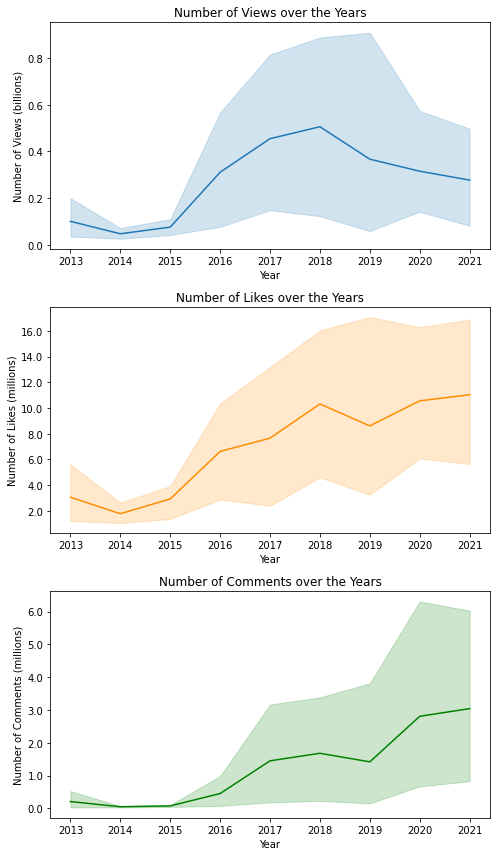

In [11]:
fig_c, ax_c = plt.subplots(3,1,figsize = (7,12))

#sns.lineplot(data=df, x='Date', y='Number of Views', ax=ax_c[0])
sns.lineplot(data=df, x='Year', y='Number of Views', ax=ax_c[0])
ax_c[0].yaxis.set_major_formatter(billions_formatter)
ax_c[0].yaxis.set_minor_formatter(NullFormatter())
ax_c[0].set_ylabel("Number of Views (billions)")
ax_c[0].set_title("Number of Views over the Years")

sns.lineplot(data=df, x='Year', y='Number of Likes', ax=ax_c[1], color='darkorange')
ax_c[1].yaxis.set_major_formatter(millions_formatter)
ax_c[1].yaxis.set_minor_formatter(NullFormatter())
ax_c[1].set_ylabel("Number of Likes (millions)")
ax_c[1].set_title("Number of Likes over the Years")

sns.lineplot(data=df, x='Year', y='Number of Comments', ax=ax_c[2], color='green')
ax_c[2].yaxis.set_major_formatter(millions_formatter)
ax_c[2].yaxis.set_minor_formatter(NullFormatter())
ax_c[2].set_ylabel("Number of Comments (millions)")
ax_c[2].set_title("Number of Comments over the Years")

fig_c.tight_layout()
plt.show()

Throughout the years, we can observe that the mean value of the views peaked at 2019 and was slowly decreasing until 2021. However, we can observe that the number of likes and comments are generally increasing. Since each youtube account can only like a video once but can view and comment as many times as they like, it can be assumed that BTS has an increasing number of people who like their videos, but less people who stream their videos repeatedly. With this, we can say that BTS is still continuing to gain popularity, and we can expect more views, likes, and comments with their upcoming MVs.